## 목표 : 생선 품종 분류 모델
    - 데이터 : 2가지 품종의 생선 데이터 fish.csv
    - 피 쳐 : Weight, Length
    - 타 겟 : Speci
    - 유 형 : 지도학습 / 분류

### (1) 모듈 로딩 & 데이터 준비 <hr>

In [194]:
import pandas as pd                                     # 데이터 파일 관련 모듈
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier      # 기계학습 관련 모듈

In [195]:
data_file = '../data/fish.csv'

In [196]:
# 5개 피쳐/특성 중 2개의 피쳐/특성 선택
fishDF = pd.read_csv(data_file, usecols=[0,1,2])
fishDF.info() # 수치, 시각화 모두 해서 확인해야

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length   159 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.9+ KB


In [197]:
# Bream, Smelt 품종 행만 추출
mask = fishDF.Species.isin(["Bream", "Smelt"]) # Boolean Indexing

# 해당 행만 도출
twoFishDF = fishDF[mask]
twoFishDF.index

# 인덱스 정리
twoFishDF.reset_index(drop=True, inplace=True)

In [198]:
## Bream, Smelt 품종명을 수치화
twoFishDF.loc[:,'Species'] = twoFishDF.Species.replace({'Bream':0,  'Smelt': 1}).copy()
twoFishDF['Species']= twoFishDF.Species.astype('int64')
twoFishDF['Species'].dtype # dtype('int64')

/var/folders/9y/lpn0hjmn5csct06t4_r5qtjr0000gn/T/ipykernel_54070/2798699763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoFishDF['Species']= twoFishDF.Species.astype('int64')


dtype('int64')

### (2) 데이터 전처리<hr>
- 정제 : 결측치, 중복값, 중복데이터, 이상치 처리
- 정규화 : 피쳐 스케일링

In [199]:
# # 표준 정규분포 => 평균 0, 표준편차 1 => z-score = (피쳐 - 평균)  / 표준편차
# twoFishDF.describe()
# twoFishDF['Weight'].mean(), twoFishDF['Length'].mean()


In [200]:
# # Weight 컬럼
# twoFishDF['Weight'].mean(), twoFishDF['Weight'].std()
# ret1 = twoFishDF.Weight - twoFishDF['Weight'].mean()
# ret1/twoFishDF['Weight'].std()
# twoFishDF.loc[:,'Weight'] = ret1
# 
# ret2 = twoFishDF.Length - twoFishDF['Length'].mean()
# ret2/twoFishDF['Length'].std()
# twoFishDF.loc[:,'Length'] = ret2
# twoFishDF
# 
# # 학습한 데이터의 평균, 표준편차를, 검증용 데이터에 그대로 이용해야 함
# # 이 과정이 피쳐가 많은 경우 함수를 쓰거나 아래 sklearn 이용


### (3) 기계학습 데이터셋 준비 => 피쳐와 타겟 분리 <hr>

In [201]:
# 피쳐/특성/속성 데이터 추출
featureDF = twoFishDF[twoFishDF.columns[1:]]
featureDF.head(2)

,Weight,Length
0,242.0,25.4
1,290.0,26.3


In [202]:
# 클래스/타겟/라벨 데이터 추출 ==> 수치화 즉 정수인코딩
targetDF = twoFishDF['Species']
targetDF.head(2)

0    0
1    0
Name: Species, dtype: int64

In [203]:
targetDF = targetDF.replace({'Bream':0, 'Smelt':1})
targetDF.dtype, targetDF.head()

(dtype('int64'),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: Species, dtype: int64)

(3-1) 학습/테스트 데이터셋 분리 <hr>
- 지도학습 중 분류 => [고려] 타겟의 비율
- 학습 : 테스트 = 80 : 20

In [204]:
# 모듈 로딩
from sklearn.model_selection import train_test_split

In [205]:
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetDF,
                                                    test_size=0.2,
                                                    stratify=targetDF)

In [206]:
# 학습 및 테스트 데이터셋 화인
print(f'학습용 데이터셋 ------>\n{X_train.shape}, {y_train.shape}')
print(f'학습용 데이터셋 ------>\n{y_train.value_counts()/y_train.shape[0]}')

print(f'테스트용 데이터셋 ------>\n{X_test.shape}, {y_test.shape}')
print(f'테스트용 데이터셋 ------>\n{y_test.value_counts()/y_test.shape}')



학습용 데이터셋 ------>
(39, 2), (39,)
학습용 데이터셋 ------>
Species
0    0.717949
1    0.282051
Name: count, dtype: float64
테스트용 데이터셋 ------>
(10, 2), (10,)
테스트용 데이터셋 ------>
Species
0    0.7
1    0.3
Name: count, dtype: float64


(3-2) 피쳐 데이터의 스케일링  <hr>
- 피쳐들의 값의 범위가 다른 것을 통일 시켜줌
- scikit-learn의 preprocessing 모듈 활용

In [207]:
# 모듈로딩
from sklearn.preprocessing import StandardScaler

In [208]:
# 표준정규분포 스케일링 : 평균 0, 편차 1
# (1) 스케일러 인스턴스 생성
# (2) 데이터에 대한 평균, 표준편차 계산 진행 : fit() 메서드
# (3) 데이터에 대한 스케일링 진행 : transform() 메서드

In [209]:
scaler = StandardScaler()

In [210]:
scaler.fit(X_train)

StandardScaler()

In [211]:
scaler.mean_

array([463.37435897,  27.33333333])

In [212]:
scaled_X_train=scaler.transform(X_train) # 검증이나 데이터에 사용할 때 새 변수명 부여해서 반복 사용
scaled_X_train

array([[-1.35731043, -1.2958906 ],
       [ 1.18278418,  0.86171753],
       [ 0.11204696,  0.41428728],
       [-1.39096217, -1.59417744],
       [-0.37743291, -0.08285746],
       [ 1.41222787,  1.20971884],
       [-0.53039537, -0.10274324],
       [ 1.56519033,  1.35886226],
       [ 0.76672629,  0.86171753],
       [-1.38729107, -1.54446296],
       [ 0.41797188,  0.46400175],
       [ 1.39693163,  1.1102899 ],
       [ 0.34149065,  0.66285964],
       [ 0.11204696,  0.3645728 ],
       [-1.3765837 , -1.4848056 ],
       [ 0.7238968 ,  0.76228859],
       [ 0.7238968 ,  0.56343069],
       [ 0.67800806,  0.66285964],
       [-1.38698514, -1.54446296],
       [-1.39463327, -1.67372059],
       [ 1.64167156,  0.96114648],
       [ 1.50400535,  1.1102899 ],
       [-0.0409155 ,  0.23531517],
       [ 0.11204696,  0.23531517],
       [-0.22447045,  0.26514386],
       [ 0.03556573,  0.3645728 ],
       [ 0.11204696,  0.33474412],
       [ 0.78508179,  0.76228859],
       [ 0.7238968 ,

In [213]:
scaler.fit_transform(X_train) # fit_transform : 검증이나 데이터에 사용하지 않을 때 사용

array([[-1.35731043, -1.2958906 ],
       [ 1.18278418,  0.86171753],
       [ 0.11204696,  0.41428728],
       [-1.39096217, -1.59417744],
       [-0.37743291, -0.08285746],
       [ 1.41222787,  1.20971884],
       [-0.53039537, -0.10274324],
       [ 1.56519033,  1.35886226],
       [ 0.76672629,  0.86171753],
       [-1.38729107, -1.54446296],
       [ 0.41797188,  0.46400175],
       [ 1.39693163,  1.1102899 ],
       [ 0.34149065,  0.66285964],
       [ 0.11204696,  0.3645728 ],
       [-1.3765837 , -1.4848056 ],
       [ 0.7238968 ,  0.76228859],
       [ 0.7238968 ,  0.56343069],
       [ 0.67800806,  0.66285964],
       [-1.38698514, -1.54446296],
       [-1.39463327, -1.67372059],
       [ 1.64167156,  0.96114648],
       [ 1.50400535,  1.1102899 ],
       [-0.0409155 ,  0.23531517],
       [ 0.11204696,  0.23531517],
       [-0.22447045,  0.26514386],
       [ 0.03556573,  0.3645728 ],
       [ 0.11204696,  0.33474412],
       [ 0.78508179,  0.76228859],
       [ 0.7238968 ,

In [214]:
# 테스트용 데이터 피쳐 스케일링
scaled_X_test = scaler.transform(X_test)
scaled_X_test

array([[-0.0409155 ,  0.26514386],
       [-0.67723933, -0.1922293 ],
       [ 0.44856437,  0.61314517],
       [-1.38790292, -1.62400612],
       [-0.30707018,  0.16571491],
       [-0.37743291,  0.46400175],
       [ 0.80037803,  0.76228859],
       [-1.3802548 , -1.50469138],
       [ 1.4887091 ,  1.35886226],
       [-1.39616289, -1.6637777 ]])

(3-3) 시각화

Text(0, 0.5, 'Length')

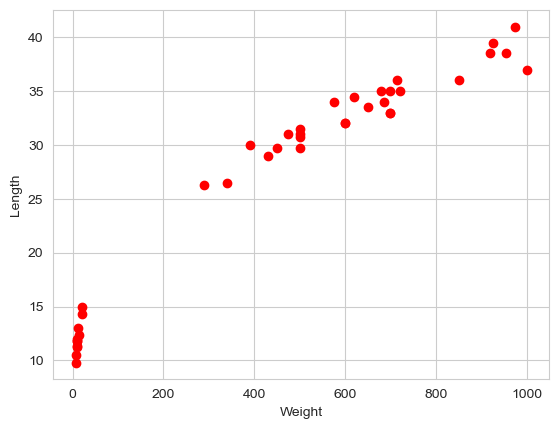

In [230]:
## 원본 데이터 시각화
import matplotlib.pyplot as plt

plt.plot(X_train.Weight, X_train.Length, 'ro')

# 학습 데이터 시각화
# plt.scatter(twoFishDF.Weight, twoFishDF.Length, c=twoFishDF.Species)
plt.xlabel('Weight')
plt.ylabel('Length')

(-2.0, 2.0)

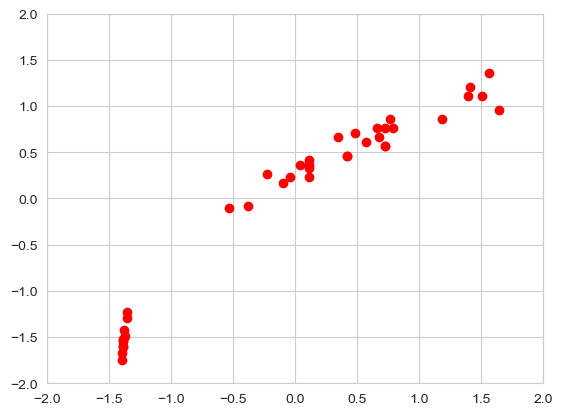

In [231]:
## => 스케일됨 데이터 시각화 ==> scaled_X_train
scaled_X_train.shape, scaled_X_train.ndim

plt.plot(scaled_X_train[:,0], scaled_X_train[:,1], 'ro')
plt.xlim(-2,2)
plt.ylim(-2,2)


## (4) 학습 진행

In [232]:
## 방법 (1) : KNN 알고리즘
fishModel = KNeighborsClassifier()
fishModel

KNeighborsClassifier()

In [233]:
# 학습
fishModel.fit(scaled_X_train, y_train)

KNeighborsClassifier()

In [244]:
## 방법 (2) : SVC
from sklearn.svm import SVC

fishmodel2=SVC()
fishmodel2.fit(scaled_X_train,y_train)

SVC()

In [255]:
## 방법 (3) : logistic regression
from sklearn.linear_model import LogisticRegression

fishmodel3 = LogisticRegression()
fishmodel3.fit(scaled_X_train,y_train)

LogisticRegression()

## (5) 테스트 진행

In [258]:
print('KNN', fishModel.score(scaled_X_test, y_test))
print('SVC', fishmodel2.score(scaled_X_test, y_test))
print('LogisticRegression', fishmodel3.score(scaled_X_test, y_test))

KNN 1.0
SVC 1.0
LogisticRegression 1.0


(6) 예측

In [246]:
## 길이 25, 무게 160인 생선의 품종 예측
new_data = pd.DataFrame([[160,25]], columns=['Weight', 'Length'])

fishModel.predict(scaled_X_test)

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1])

In [247]:
scaled_new_data = scaler.transform(new_data)
scaled_new_data

array([[-0.92809776, -0.23200087]])

In [248]:
# 예측
fishModel.predict(scaled_new_data)

array([0])

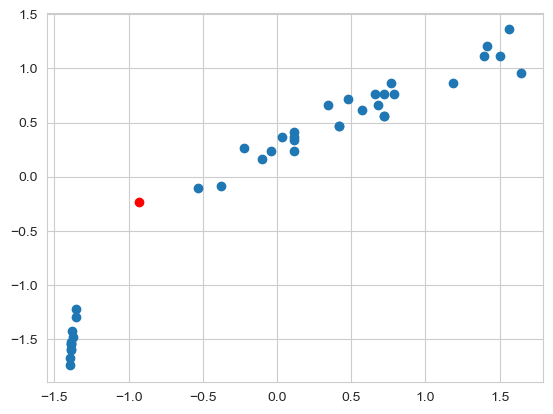

In [264]:
plt.scatter(scaled_X_train[:,0], scaled_X_train[:,1])
plt.plot(scaled_new_data[:,0], scaled_new_data[:,1],'ro')